Medir el tiempo de nodos en buffer de 2km al punto más cercano de López Mateos:

1. Descargar López Mateos y generar buffer de 2km [DONE]
2. Descargar edges [osmnx > edges_speed] y nodos [osmnx > nodes] dentro de ese buffer con graph_from_hippo [DONE]
3. Encontrar qué edges son de López Mateos [DONE]
4. De esos edges, encontrar que nodos son de López Mateos [DONE]
5. Calcular la distancia de todos los nodos a los de López Mateos
   (Museo_ciencias_ambientales>26cMCA .ipynb cell 35 >> aup.calculate_distance_nearest_poi)
6. Agrupar a hexres9

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-02-09 20:02:06 Configured OSMnx 1.1.1
2023-02-09 20:02:06 HTTP response caching is on


## Loading data

<AxesSubplot:>

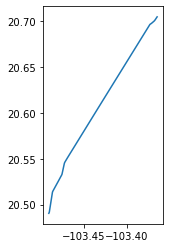

In [2]:
#Importing gdf with Avenue López Mateos as line 
lopezmateos_gdf = gpd.read_file("../../data/external/db_segundopiso_temp/lopezmateos.gpkg")
lopezmateos_gdf.plot()

<AxesSubplot:>

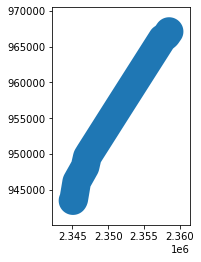

In [3]:
#Creating 2km buffer
lopezmateos_gdf_temp = lopezmateos_gdf.copy()
lopezmateos_gdf_temp = lopezmateos_gdf_temp.to_crs("EPSG:6372")
buffer_2km = lopezmateos_gdf_temp.buffer(2000)
buffer_2km.plot()

## Getting nodes from López Mateos

1. Getting edges and nodes from buffer_2km
2. From edges, find streets named like López Mateos
3. From those streets, get the nodes that the lines go from/to

1. Getting edges and nodes from buffer_2km

In [4]:
#graph_from_hippo(gdf, schema, edges_folder='edges', nodes_folder='nodes')
graph, nodes_2kmgdf, edges_2kmgdf = aup.graph_from_hippo(buffer_2km, 'osmnx', edges_folder='edges_speed', nodes_folder='nodes')

2023-02-09 20:03:10 Created graph from node/edge GeoDataFrames


In [5]:
edges_2kmgdf.head(1)

,,,osmid,oneway,lanes,name,highway,length,geometry,grade,grade_abs,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
u,v,key,,,,,,,,,,,,,,,,,,,
4649110319,8764357413,0,727557563,False,None,None,unclassified,37.557,"LINESTRING (-103.49277 20.47597, -103.49247 20...",0.0,0.0,None,None,None,None,None,None,None,None,4.0,0.563355


In [6]:
#Finding None values in 'name' and changing them to 'sin nombre'
#First we create a boolean mask where there is nan in 'name'
idx = edges_2kmgdf['name'].isna()
#Then, in that boolean mask, we change 'name' to 'sin nombre'
edges_2kmgdf.loc[idx, 'name'] = 'sin nombre'

2. From edges, find streets named like López Mateos

In [7]:
#Finding streets named 'Mateos' (List comprehensions)
calles_lm_lst = [x for x in list(edges_2kmgdf.name.unique()) if 'Mateos' in x]
calles_lm_lst

['Lateral de López Mateos Sur',
 'Avenida Adolfo López Mateos Sur',
 'Avenida Adolfo López Mateos Norte',
 "['Avenida Adolfo López Mateos Norte', 'Avenida Adolfo López Mateos Sur']",
 "['Avenida Adolfo López Mateos Norte', 'Circunvalación Jorge Álvarez del Castillo']",
 'Calle López Mateos',
 "['Avenida Adolfo López Mateos Sur', 'Avenida López Mateos Sur']",
 'Avenida López Mateos Sur',
 'Farmacias Guadalajara López Mateos Sur',
 "['Autopista Guadalajara - Colima', 'Avenida López Mateos Sur']"]

<AxesSubplot:>

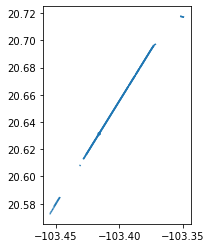

In [8]:
#Results: There're still missing lines. 
edges_2kmgdf.loc[edges_2kmgdf.name.isin(calles_lm_lst)].plot()

In [9]:
#Export to db to open in GIS and find missing lines
#aup.gdf_to_db_slow(edges_gdf,"edges_lopezmateos", 'segundopiso', if_exists='replace')

<AxesSubplot:>

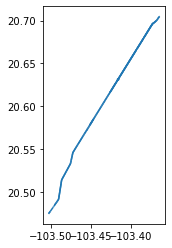

In [10]:
add_tolst = ['Autopista Guadalajara - Colima','Circunvalación Jorge Álvarez del Castillo']
for st in add_tolst:
    if st not in calles_lm_lst:
        calles_lm_lst.append(st)

remove_lst = ['Farmacias Guadalajara López Mateos Sur','Calle López Mateos']
for st in remove_lst:
    if st in calles_lm_lst:
        calles_lm_lst.remove(st)

#calles_lm_lst
edges_2kmgdf.loc[edges_2kmgdf.name.isin(calles_lm_lst)].plot()

In [11]:
edges_lm_gdf = edges_2kmgdf.loc[edges_2kmgdf.name.isin(calles_lm_lst)]
len(edges_lm_gdf)

845

In [22]:
aup.gdf_to_db_slow(edges_lm_gdf,"edges_lopezmateos", 'segundopiso', if_exists='replace')

3. From those streets, get the nodes that the lines go from/to

In [12]:
#The nodes are stored in the index of edges_lm_gdf
edges_index = edges_lm_gdf.index
edges_index

MultiIndex([(8407976153, 1760037166, 0),
            (8636724621, 8776027172, 0),
            (8636724626, 8636724621, 0),
            (1760037166, 8636724626, 0),
            (8407976154, 8407976153, 0),
            (1653526239, 6345478758, 0),
            (8317791436, 2882811501, 0),
            (6345478758, 8324054199, 0),
            (2882807997, 2882807994, 0),
            (2882811501, 1383913684, 0),
            ...
            (1207849850, 6345478759, 0),
            (6345478759, 3022414405, 0),
            (8324054199, 2882807995, 0),
            (2978021614, 1041108864, 0),
            (1041108864, 1347475658, 0),
            (1450183997, 8323161278, 0),
            (1347475658, 1450183997, 0),
            (2978021612, 6511832111, 0),
            (8323161278, 1041865204, 0),
            (8324161160, 1347454171, 0)],
           names=['u', 'v', 'key'], length=845)

In [13]:
#From each tupple of the multiindex we'll keep the first[0] and second[1] values.
nodes_lm_lst = []
for tupp in edges_index:
    if tupp[0] not in nodes_lm_lst:
        nodes_lm_lst.append(tupp[0])
    if tupp[1] not in nodes_lm_lst:
        nodes_lm_lst.append(tupp[1])
        
len(nodes_lm_lst)

851

In [19]:
nodes_lm_gdf = nodes_2kmgdf.loc[nodes_2kmgdf.index.isin(nodes_lm_lst)]
nodes_lm_gdf.head(1)

,x,y,street_count,geometry
osmid,,,,
283528400,-103.416184,20.630711,3,POINT (-103.41618 20.63071)


## Getting distance

In [20]:
#For calculate_distance_nearest_poi to work we need osmid to be a column, not the index
nodes_lm_gdf = nodes_lm_gdf.reset_index() 
nodes_lm_gdf.head(1)

,osmid,x,y,street_count,geometry
0,283528400,-103.416184,20.630711,3,POINT (-103.41618 20.63071)


In [21]:
#calculate_distance_nearest_poi(gdf_f, nodes, edges, amenity_name, column_name, wght='length', max_distance=(0,'distance_node')):

nodes_dist = aup.calculate_distance_nearest_poi(nodes_lm_gdf, nodes_2kmgdf, edges_2kmgdf, 'lpz_mateos', 'osmid', wght='time_min')

In [22]:
nodes_dist.head()

,x,y,street_count,geometry,dist_lpz_mateos
osmid,,,,,
28791285,-103.386953,20.674556,3,POINT (-103.38695 20.67456),0.155880
28791354,-103.368559,20.674565,4,POINT (-103.36856 20.67456),30.255253
28791359,-103.371654,20.674449,4,POINT (-103.37165 20.67445),25.095806
28791397,-103.387021,20.674199,3,POINT (-103.38702 20.67420),0.700245
28791518,-103.402947,20.674933,3,POINT (-103.40295 20.67493),23.605428


<AxesSubplot:>

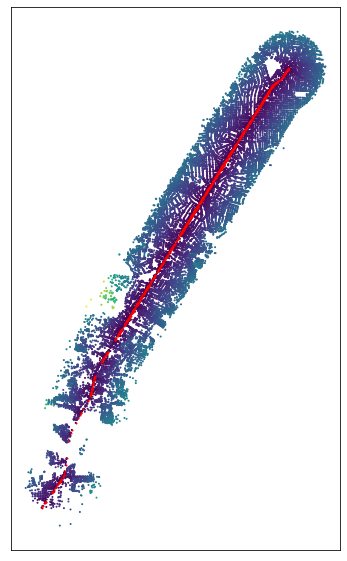

In [23]:
fig,ax = plt.subplots(figsize=(10,10))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

nodes_lm_gdf.plot(color='red', markersize=1, ax=ax, zorder=2)
nodes_dist.plot('dist_lpz_mateos', markersize=1, ax=ax)

In [42]:
aup.gdf_to_db_slow(nodes_dist,"nodes_dist_lopezmateos", 'segundopiso', if_exists='replace')

## Nodes to hex

Download hexres9 hex

In [24]:
res = 9
folder = 'hexgrid'
city = 'Guadalajara'
table = f'hexgrid_{res}_city'

query = f"SELECT * FROM {folder}.{table} WHERE \"metropolis\" LIKE \'{city}\'"
hex_res_9 = aup.gdf_from_query(query, geometry_col='geometry')
hex_res_9 = hex_res_9[[f'hex_id_{res}','geometry','metropolis']]
print(hex_res_9.shape)
hex_res_9.head(2)

(28610, 3)


,hex_id_9,geometry,metropolis
0,8949abc9ca7ffff,"POLYGON ((-103.63759 20.41626, -103.63968 20.4...",Guadalajara
1,8949abc9d43ffff,"POLYGON ((-103.63836 20.43005, -103.63957 20.4...",Guadalajara


Grouping nodes by hex (mean)

In [25]:
nodes_dist.head(1)

,x,y,street_count,geometry,dist_lpz_mateos
osmid,,,,,
28791285,-103.386953,20.674556,3,POINT (-103.38695 20.67456),0.15588


In [26]:
#For group_by_hex_mean to work we need osmid to be a column, not the index
nodes_dist = nodes_dist.reset_index() 
nodes_dist.head(1)

,osmid,x,y,street_count,geometry,dist_lpz_mateos
0,28791285,-103.386953,20.674556,3,POINT (-103.38695 20.67456),0.15588


In [27]:
hex_tmp = hex_res_9[['hex_id_9','geometry']]
res = 9
index_column = 'dist_lpz_mateos'

hex_res_9_idx = aup.group_by_hex_mean(nodes_dist, hex_tmp, res, index_column)
hex_res_9_idx = hex_res_9_idx.loc[hex_res_9_idx[index_column]>0].copy()

<AxesSubplot:>

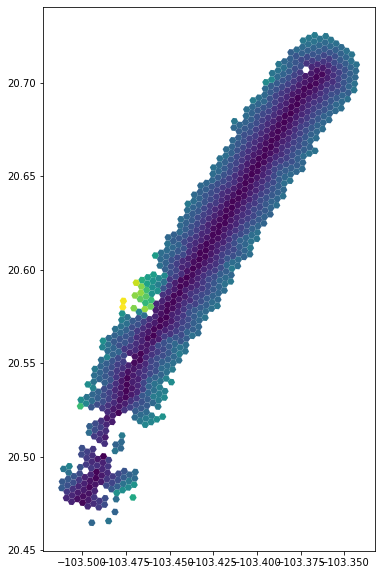

In [28]:
fig,ax = plt.subplots(figsize=(10,10))
hex_res_9_idx.plot('dist_lpz_mateos',ax=ax)

In [58]:
aup.gdf_to_db_slow(hex_res_9_idx,"dist_alopezmateos_hexres9", 'segundopiso', if_exists='replace')